In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [2]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Gemastik13/Indonesian Sentiment Twitter Dataset Labeled.csv', error_bad_lines=False, sep='\t')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


sentimen                                              Tweet
0        -1  lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1        -1  kita lanjutkan saja diam ini hingga kau dan ak...
2         1  doa rezeki tak putus inna haa zaa larizquna ma...
3         1  makasih loh ntar kita bagi hasil aku 99 9 sisa...
4        -1  aku tak faham betul jenis orang malaysia yang ...

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
stop_words = stopwords.words('indonesian')

In [6]:
'''
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)
'''

'\ndef preprocess(text, stem=False):\n    # Remove link,user and special characters\n    text = re.sub(TEXT_CLEANING_RE, \' \', str(text).lower()).strip()\n    tokens = []\n    for token in text.split():\n        if token not in stop_words:\n            tokens.append(token)\n    return " ".join(tokens)\n'

#Preprocessing

##Replace the contractions for their actual words

In [7]:
import io
import time
from datetime import timedelta
import logging
logging.basicConfig(level=logging.INFO)
#import gensim
#from gensim.models.wrappers import FastText

def _normalize_contractions_text(text):
  contractions = slang_dict
  new_token_list = []
  token_list = text.split()
  for word_pos in range(len(token_list)):
    word = token_list[word_pos]
    first_upper = False
    if word[0].isupper():
      first_upper = True
    if word.lower() in contractions:
      replacement = contractions[word.lower()]
      if first_upper:
        replacement = replacement[0].upper()+replacement[1:]
      replacement_tokens = replacement.split()
      if len(replacement_tokens)>1:
        new_token_list.append(replacement_tokens[0])
        #print(new_token_list)
        new_token_list.append(replacement_tokens[1])
        #print(new_token_list)
      else:
        new_token_list.append(replacement_tokens[0])
        #print(new_token_list)
    else:
      new_token_list.append(word)
      #print(new_token_list)
  sentence = " ".join(new_token_list).strip(" ")
  return(sentence)
  

##Lemmatization

In [8]:
# initiate lemmetization
import spacy
nlp=spacy.blank('id') 
def lemmatize(sentence):
  new_sent = []
  doc = nlp(sentence)
  for token in doc:
      ori = token.text
      lemma = token.lemma_  # token.lemma is integer index
      new_sent.append(lemma)
  return " ".join(new_sent)

##Spell checking

In [9]:
#!pip install symspellpy

###Downloading data for spell checking

In [10]:
#! wget -O cc.bin https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz

In [11]:
#! fasttext nn cc.bin 10

###Instantiate spell checker

In [12]:
#!pip install fasttext

In [13]:
#import fasttext.util 

In [14]:

#fasttext.util.download_model('id', if_exists='ignore')
#ft = fasttext.load_model('/content/cc.id.300.bin')

In [15]:
#from gensim.test.utils import common_texts
#model = FastText(size=4, window=3, min_count=1)  # instantiate
#model.build_vocab(sentences=common_texts)
#model.train(sentences=common_texts, total_examples=len(common_texts), epochs=10)

###Function for spell checking

In [16]:
#words=ft.words
#w_rank={}
#for i,word in enumerate(words):
#  w_rank[word] = i
#WORDS =  w_rank

In [17]:
'''
from collections import Counter
def words(text):
  return re.findall(r'\w+',text.lower())

def P(word):
  return - WORDS.get(word,0)

def correction(word):
  return max(candidates(word),key=P)

def candidates(word):
  return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words):
  return set(w for w in words if w in WORDS)

def edits1(word):
  letters = 'abcdefghijklmnopqrstuvwxyz'
  splits=[(word[:1],word[i:]) for i in range(len(word)+1)]
  deletes=[L+R[1:] for L,R in splits if R]
  transposes=[L+R[1]+R[0]+R[2:] for L,R in splits if len(R)>1]
  replaces=[L+c+R[1:] for L,R in splits if R for c in letters]
  inserts=[L+c+R for L,R in splits for c in letters]
  return set(deletes+transposes+replaces+inserts)

def edits2(word):
  return (e2 for e1 in edits1(word) for e2 in edits1(e1))
'''

"\nfrom collections import Counter\ndef words(text):\n  return re.findall(r'\\w+',text.lower())\n\ndef P(word):\n  return - WORDS.get(word,0)\n\ndef correction(word):\n  return max(candidates(word),key=P)\n\ndef candidates(word):\n  return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])\n\ndef known(words):\n  return set(w for w in words if w in WORDS)\n\ndef edits1(word):\n  letters = 'abcdefghijklmnopqrstuvwxyz'\n  splits=[(word[:1],word[i:]) for i in range(len(word)+1)]\n  deletes=[L+R[1:] for L,R in splits if R]\n  transposes=[L+R[1]+R[0]+R[2:] for L,R in splits if len(R)>1]\n  replaces=[L+c+R[1:] for L,R in splits if R for c in letters]\n  inserts=[L+c+R for L,R in splits for c in letters]\n  return set(deletes+transposes+replaces+inserts)\n\ndef edits2(word):\n  return (e2 for e1 in edits1(word) for e2 in edits1(e1))\n"

##Preprocessing Joined Function

In [18]:
import string    
punc = [i for i in string.punctuation]
nltk.download('punkt')
nltk.download('stopwords')



'''
def preprocess_test(tweet):
    tweet = tweet.lower()#make all tweet lower case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
    tweet = re.sub('@[^\s]+', '', tweet) # remove usernames
    tweet = re.sub(r'#([^\s]+)', r'', tweet) # remove  #hashtag
    tweet = re.sub(r'[Rr][Tt]',r'',tweet)#remove RT
    #Remove emoji
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    tweet=regrex_pattern.sub(r'',tweet)
    return tweet
'''

def preprocess_tweet(tweet):
    tweet = tweet.lower()#make all tweet lower case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet) # remove URLs
    tweet = re.sub('@[^\s]+', ' ', tweet) # remove usernames
    tweet = re.sub(r'#([^\s]+)', r' ', tweet) # remove  #hashtag
    tweet = re.sub(r'\b[Rr][Tt]\b',r' ',tweet)#remove RT
    #Remove emoji
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    tweet=regrex_pattern.sub(r'',tweet)
    tweet=re.sub('\d',' ',tweet)#remove digit
    #replace punctuation with whitespace 
    for p in punc:
        tweet=tweet.replace(p,' ')
    
    tweet=re.compile(r"\s+").sub(" ", tweet).strip()#remove additional whitespace
    #tweet = tweet.translate(str.maketrans(' ',' ',string.punctuation))#remove punctuation
    tokens = nltk.tokenize.word_tokenize(tweet)
    
    #Remove punctuation
    listStopword =  set(stopwords.words('indonesian'))
    removed = []
    for t in tokens:
        if t not in listStopword:
            removed.append(t)
    """        
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    #tokenize
    tokenize=[]
    for r in removed:
        katadasar = stemmer.stem(r)
        tokenize.append(katadasar)
    """
    tweet = " ".join(removed)
#    tweet = preprocess_tweet(tweet)
#    tweet = _normalize_contractions_text(tweet)
#    tweet = lemmatize(tweet)
    return tweet
    #" ".join(removed)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
%%time
df['Tweet'] = df['Tweet'].apply(lambda x: preprocess_tweet(x))


CPU times: user 5.63 s, sys: 212 ms, total: 5.85 s
Wall time: 5.86 s


In [20]:
df.head()

sentimen                                              Tweet
0        -1  lagu bosan save ni huhuhuhuhuhuhuhuhuhuuuuuuuu...
1        -1  lanjutkan diam kau mengerti kebersamaan meliba...
2         1  doa rezeki putus inna haa zaa larizquna maa la...
3         1                     makasih loh ntar hasil sisanya
4        -1  faham jenis orang malaysia reti nak sangkut ho...

In [21]:
X = df.Tweet.copy()
y = df.sentimen.copy()

In [22]:
print(X.shape)
print(y.shape)

(10806,)
(10806,)


#Preparing The Input and Output

##Tokenizing

In [23]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 10806 documents
10000 words in dictionary
Top 5 most common words are: [('yg', 1388), ('orang', 872), ('ni', 793), ('ya', 783), ('nak', 704)]


In [24]:
X_seq = tk.texts_to_sequences(X)
print('"{}" is converted into {}'.format(X[0], X_seq[0]))


"lagu bosan save ni huhuhuhuhuhuhuhuhuhuuuuuuuuuuuuuu" is converted into [257, 772, 1393, 3, 8926]


##One-Hot Encoding The Input

In [25]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_oh = one_hot_seq(X_seq)
#X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_seq[0], X_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_oh[0].sum()))

"[257, 772, 1393, 3, 8926]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 5.0 features with a value of 1.


In [26]:
print(X_oh.shape)

(10806, 10000)


##Label Encoding The Output

In [27]:
le = LabelEncoder()
y_le = le.fit_transform(y)
#y_test_le = le.transform(y_test)
y_oh = to_categorical(y_le)
#y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y[0], y_le[0]))
print('"{}" is converted into {}'.format(y_le[0], y_oh[0]))
print(y_oh.shape)

"-1" is converted into 0
"0" is converted into [1. 0. 0.]
(10806, 3)


In [28]:
y_oh

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [29]:
y_le

array([0, 0, 2, ..., 2, 2, 2])

In [30]:
np.unique(y_le)

array([0, 1, 2])

##Train and Test Split

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X_oh, y_oh, test_size=0.2, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train.shape[0] == y_train.shape[0]

print('Shape of validation set:',X_valid.shape)
print('Shape of validation set:',y_valid.shape)
print('Shape of validation set:',X_train.shape)
print('Shape of validation set:',y_train.shape)

Shape of validation set: (2162, 10000)
Shape of validation set: (2162, 3)
Shape of validation set: (8644, 10000)
Shape of validation set: (8644, 3)


#Deep Learning Model

##1. Base Model

In [32]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [33]:
def deep_model(model, X, y):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [34]:
base_history = deep_model(base_model, X_train, y_train)

###Base Model Evaluation

In [35]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

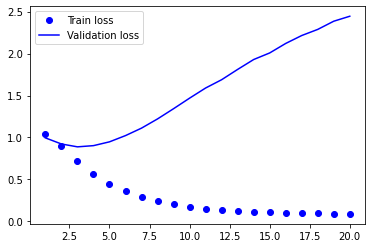

In [36]:
eval_metric(base_history, 'loss')

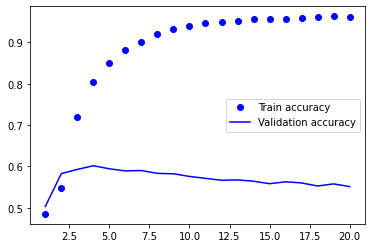

In [37]:
eval_metric(base_history, 'accuracy')

##Layer-Reduced Model

In [38]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


In [39]:
reduced_history = deep_model(reduced_model, X_train, y_train)

###Comparing with The Base Model

In [40]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

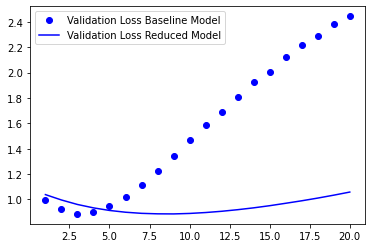

In [41]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')

##Regularized-Kernel Model

In [42]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [43]:
reg_history = deep_model(reg_model, X_train, y_train)

###Comparing with The Base Model

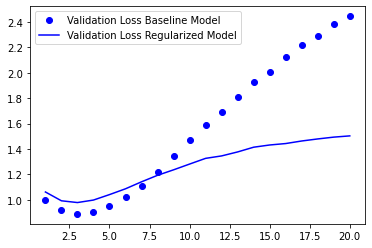

In [44]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

##Dropout-Layer-Added Model

In [45]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [46]:
drop_history = deep_model(drop_model, X_train, y_train)

###Comparing with The Base Model

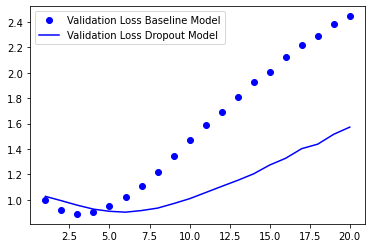

In [47]:
compare_loss_with_baseline(drop_history, 'Dropout Model')

##Validating All Models 

In [48]:
def test_model(model, epoch_stop):
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_valid, y_valid)
    
    return results

In [49]:
def predicted_todf(predicted):
    list_predict = predicted.tolist()
    df_predict = pd.DataFrame(list_predict, columns=['-1', '0', '1'])

    predict_sentiment = []

    for i in range(len(df_predict)):
        if (df_predict.iloc[i, 0] >  df_predict.iloc[i, 1]) and (df_predict.iloc[i, 0] > df_predict.iloc[i, 2]):
            predict_sentiment.append(-1)
        elif (df_predict.iloc[i, 1] >  df_predict.iloc[i, 0]) and (df_predict.iloc[i, 1] > df_predict.iloc[i, 2]):
            predict_sentiment.append(0)
        elif (df_predict.iloc[i, 2] >  df_predict.iloc[i, 0]) and (df_predict.iloc[i, 2] > df_predict.iloc[i, 1]):
            predict_sentiment.append(1)
        else:
            predict_sentiment.append(np.nan)
    df_result = pd.DataFrame(predict_sentiment, columns=['sentiment'])
    return df_result

In [50]:
y_to_test = predicted_todf(y_valid)
y_to_test.shape

(2162, 1)

In [51]:
base_predict = base_model.predict(X_valid)
base_predict.shape

(2162, 3)

In [52]:
base_predict_df = predicted_todf(base_predict)
base_predict_df.shape

(2162, 1)

In [53]:
reduced_predict = reduced_model.predict(X_valid)
reduced_predict.shape

(2162, 3)

In [54]:
reduced_predict_df = predicted_todf(reduced_predict)
reduced_predict_df.shape

(2162, 1)

In [55]:
reg_predict = reg_model.predict(X_valid)
reg_predict.shape

(2162, 3)

In [56]:
reg_predict_df = predicted_todf(reg_predict)
reg_predict_df.shape

(2162, 1)

In [57]:
drop_predict = drop_model.predict(X_valid)
drop_predict.shape

(2162, 3)

In [58]:
drop_predict_df = predicted_todf(drop_predict)
drop_predict_df.shape

(2162, 1)

In [59]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from itertools import cycle
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###Base

In [60]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

68/68 [==============================] - 0s 2ms/step - loss: 2.6811 - accuracy: 0.5523
/n
Test accuracy of baseline model: 55.23%


In [61]:
def plot_roc(base_predict_df, y_to_test):
    base_matrix = classification_report(base_predict_df,y_to_test)
    print('Classification report : \n', base_matrix)
    y_score = label_binarize(base_predict_df,classes=[-1,0,1])
    y_test = label_binarize(y_to_test,classes=[-1,0,1])
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(-1,2):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    import matplotlib.pyplot as plt

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure(figsize=(20,10))
    sns.set_style('darkgrid')

    plt.subplot(1,2,1)
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")


    plt.subplot(1,2,2)
    lw=2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(-1,2), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

Classification report : 
               precision    recall  f1-score   support

          -1       0.46      0.47      0.47       558
           0       0.65      0.65      0.65      1090
           1       0.45      0.43      0.44       514

    accuracy                           0.55      2162
   macro avg       0.52      0.52      0.52      2162
weighted avg       0.55      0.55      0.55      2162



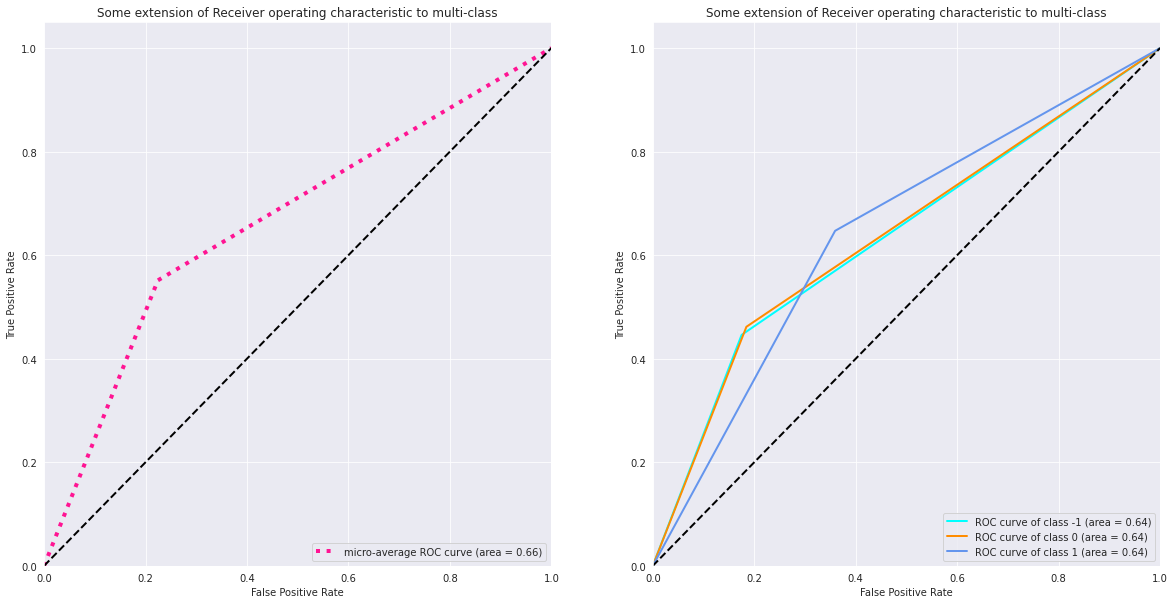

In [62]:
plot_roc(base_predict_df, y_to_test)

###Reduced Layer

In [63]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

68/68 [==============================] - 0s 2ms/step - loss: 1.3616 - accuracy: 0.5800
/n
Test accuracy of reduced model: 58.00%


Classification report : 
               precision    recall  f1-score   support

          -1       0.48      0.53      0.50       512
           0       0.73      0.65      0.69      1215
           1       0.44      0.51      0.47       435

    accuracy                           0.59      2162
   macro avg       0.55      0.56      0.55      2162
weighted avg       0.61      0.59      0.60      2162



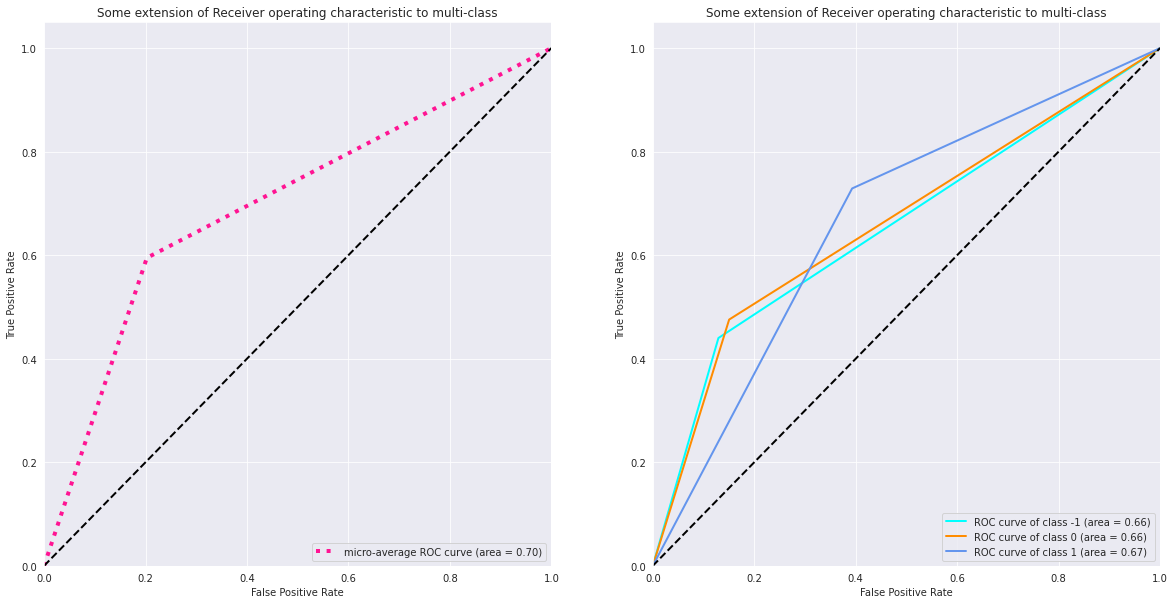

In [64]:
plot_roc(reduced_predict_df, y_to_test)

###Regularized

In [65]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

68/68 [==============================] - 0s 3ms/step - loss: 1.5524 - accuracy: 0.5754
/n
Test accuracy of regularized model: 57.54%


Classification report : 
               precision    recall  f1-score   support

          -1       0.46      0.54      0.50       494
           0       0.72      0.65      0.68      1196
           1       0.45      0.48      0.46       472

    accuracy                           0.59      2162
   macro avg       0.54      0.56      0.55      2162
weighted avg       0.60      0.59      0.59      2162



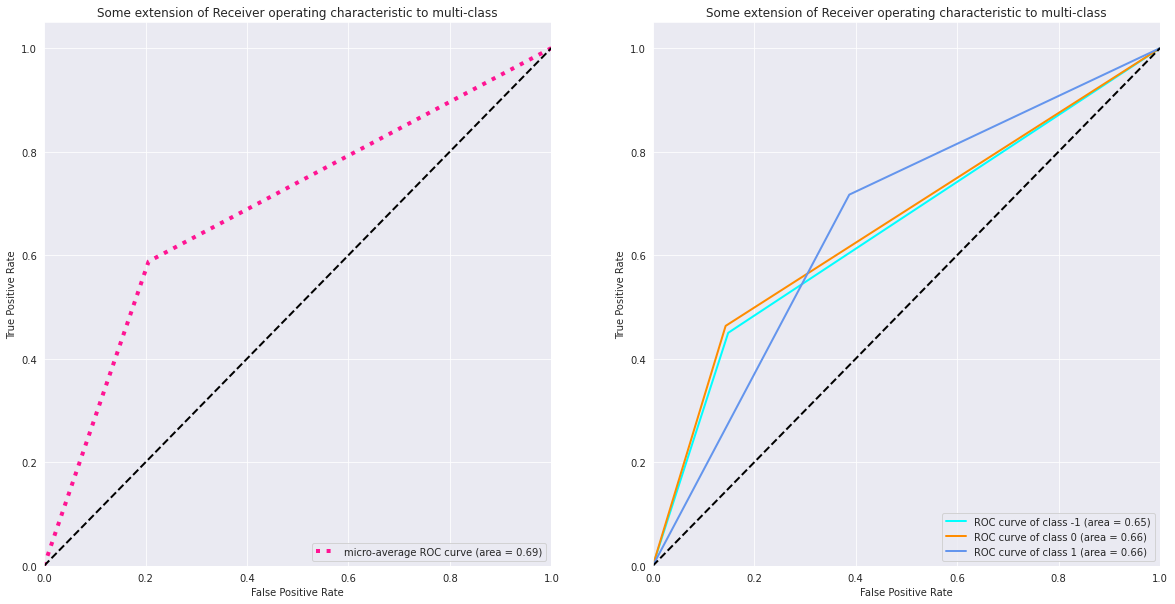

In [66]:
plot_roc(reg_predict_df, y_to_test)

###Dropout

In [67]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

68/68 [==============================] - 0s 2ms/step - loss: 1.9253 - accuracy: 0.5800
/n
Test accuracy of dropout model: 58.00%


Classification report : 
               precision    recall  f1-score   support

          -1       0.46      0.51      0.48       515
           0       0.71      0.65      0.68      1193
           1       0.46      0.50      0.48       454

    accuracy                           0.59      2162
   macro avg       0.54      0.55      0.55      2162
weighted avg       0.60      0.59      0.59      2162



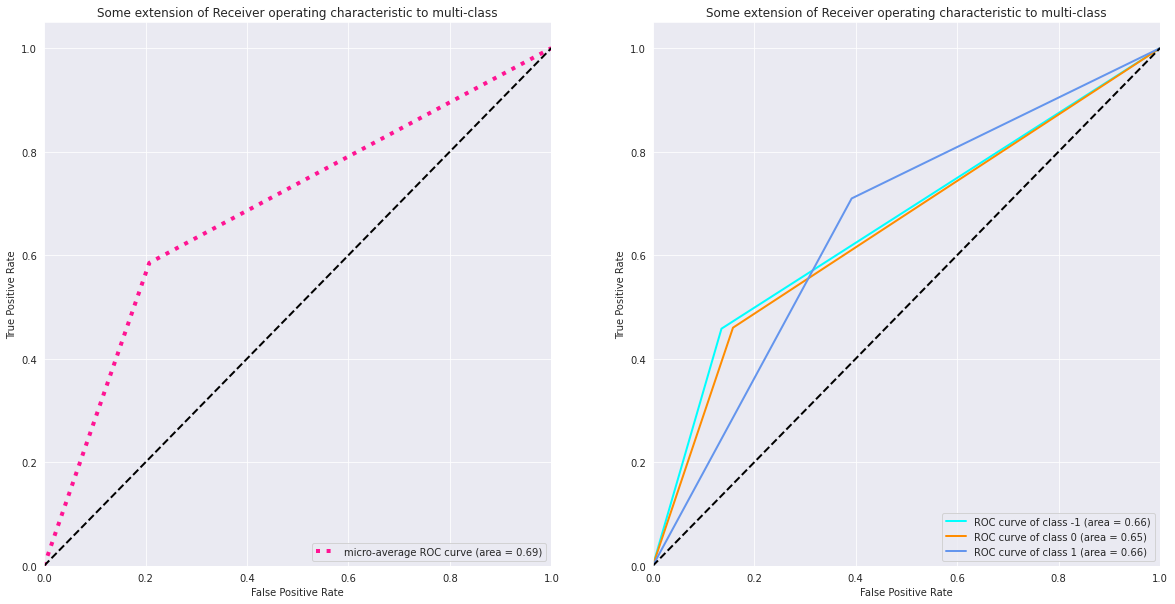

In [68]:
plot_roc(drop_predict_df, y_to_test)

#Deploy Model to Predict The Sentiment

In [69]:
omni = pd.read_csv('/content/drive/My Drive/Gemastik13/omnibuslaw.csv')
omni.tail()

0                          1  ...                      5   6
6759  1301331150154022912  2020-09-03 01:28:18+00:00  ...  @PDI_Perjuangan @BPip NaN
6760  1301329820802932736  2020-09-03 01:23:01+00:00  ...                    NaN NaN
6761  1301329740419051520  2020-09-03 01:22:42+00:00  ...                    NaN NaN
6762  1301329650103103488  2020-09-03 01:22:20+00:00  ...                    NaN NaN
6763  1301324883226320897  2020-09-03 01:03:24+00:00  ...                    NaN NaN

[5 rows x 7 columns]

In [70]:
omni = omni.rename(columns={omni.columns[0]: "id", 
                   omni.columns[1]: "date", 
                   omni.columns[2]: "text", 
                   omni.columns[3]: "total_retweets",
                   omni.columns[4]: 'total_favorites',
                   omni.columns[5]: "mentions",
                   omni.columns[6]: "geo"})
omni.head()

id                       date  ... mentions  geo
0  1301815267954061312  2020-09-04 09:32:01+00:00  ...      NaN  NaN
1  1301815086378491906  2020-09-04 09:31:17+00:00  ...      NaN  NaN
2  1301814678675271681  2020-09-04 09:29:40+00:00  ...      NaN  NaN
3  1301814467383050242  2020-09-04 09:28:50+00:00  ...      NaN  NaN
4  1301814167431593984  2020-09-04 09:27:38+00:00  ...      NaN  NaN

[5 rows x 7 columns]

In [71]:
omni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6764 entries, 0 to 6763
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               6764 non-null   int64  
 1   date             6764 non-null   object 
 2   text             6764 non-null   object 
 3   total_retweets   6764 non-null   int64  
 4   total_favorites  6764 non-null   int64  
 5   mentions         770 non-null    object 
 6   geo              0 non-null      float64
dtypes: float64(1), int64(3), object(3)
memory usage: 370.0+ KB


##Preprocess

In [72]:
omni_dropped = omni.dropna(axis=1)
omni_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6764 entries, 0 to 6763
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               6764 non-null   int64 
 1   date             6764 non-null   object
 2   text             6764 non-null   object
 3   total_retweets   6764 non-null   int64 
 4   total_favorites  6764 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 264.3+ KB


In [73]:
import datetime
omni_dropped['dates'] = pd.to_datetime(omni_dropped['date'], format="%Y-%m-%dT%H:%M:%S")
omni_dropped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


id  ...                     dates
0  1301815267954061312  ... 2020-09-04 09:32:01+00:00
1  1301815086378491906  ... 2020-09-04 09:31:17+00:00
2  1301814678675271681  ... 2020-09-04 09:29:40+00:00
3  1301814467383050242  ... 2020-09-04 09:28:50+00:00
4  1301814167431593984  ... 2020-09-04 09:27:38+00:00

[5 rows x 6 columns]

In [74]:
omni_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6764 entries, 0 to 6763
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   id               6764 non-null   int64              
 1   date             6764 non-null   object             
 2   text             6764 non-null   object             
 3   total_retweets   6764 non-null   int64              
 4   total_favorites  6764 non-null   int64              
 5   dates            6764 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(3), object(2)
memory usage: 317.2+ KB


In [75]:
from datetime import datetime, timezone
import pytz

def utc_to_local(utc_dt):
    WIB = pytz.timezone("Asia/Jakarta")
    return utc_dt.astimezone(WIB)

In [76]:
omni_dropped['dates'] = omni_dropped['dates'].apply(lambda x: utc_to_local(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [77]:
omni_dropped['hour'] = omni_dropped['dates'].apply(lambda x: pd.to_datetime(x).hour)
omni_dropped['day_of_week'] = omni_dropped['dates'].apply(lambda x: pd.to_datetime(x).weekday())
omni_dropped['day'] = omni_dropped['dates'].apply(lambda x: pd.to_datetime(x).day)
omni_dropped['month'] = omni_dropped['dates'].apply(lambda x: pd.to_datetime(x).month)
#omni_dropped['complete_date'] = omni_dropped['dates'].apply(lambda x: pd.to_datetime(x).strptime('%d-%m-%Y'))


In [78]:
omni_dropped.head()

id                       date  ... day  month
0  1301815267954061312  2020-09-04 09:32:01+00:00  ...   4      9
1  1301815086378491906  2020-09-04 09:31:17+00:00  ...   4      9
2  1301814678675271681  2020-09-04 09:29:40+00:00  ...   4      9
3  1301814467383050242  2020-09-04 09:28:50+00:00  ...   4      9
4  1301814167431593984  2020-09-04 09:27:38+00:00  ...   4      9

[5 rows x 10 columns]

In [79]:
pd.options.display.max_colwidth = 1000

In [80]:
omni_clean = omni_dropped.drop(columns='date')
omni_clean.head(10)

id  ... month
0  1301815267954061312  ...     9
1  1301815086378491906  ...     9
2  1301814678675271681  ...     9
3  1301814467383050242  ...     9
4  1301814167431593984  ...     9
5  1301814038733623297  ...     9
6  1301813975210954752  ...     9
7  1301810780698886144  ...     9
8  1301808956998733824  ...     9
9  1301806495739252736  ...     9

[10 rows x 9 columns]

In [81]:
test = omni_clean.copy()
test['text'] = test['text'].str.extract(r'(.+)')
test['text'] = test['text'].apply(preprocess_tweet)
#arr = pd.Series(arr)

test.head(10)

id  ... month
0  1301815267954061312  ...     9
1  1301815086378491906  ...     9
2  1301814678675271681  ...     9
3  1301814467383050242  ...     9
4  1301814167431593984  ...     9
5  1301814038733623297  ...     9
6  1301813975210954752  ...     9
7  1301810780698886144  ...     9
8  1301808956998733824  ...     9
9  1301806495739252736  ...     9

[10 rows x 9 columns]

In [82]:
df_test = test.copy()
#.rename(columns={'kalimat' : 'tweets'})
df_test.head()

id  ... month
0  1301815267954061312  ...     9
1  1301815086378491906  ...     9
2  1301814678675271681  ...     9
3  1301814467383050242  ...     9
4  1301814167431593984  ...     9

[5 rows x 9 columns]

In [83]:
df_test = test.copy()

text = df_test.text.copy()
tk.fit_on_texts(text)


In [84]:
text_seq = tk.texts_to_sequences(text)
print('"{}" is converted into {}'.format(text[0], text_seq[0]))

"omnibuslaw pemberi kerja dilarang membayar gaji dibawah gaji minimum" is converted into [48, 1777, 2, 1152, 641, 664, 1191, 664, 378]


In [85]:
text_oh = one_hot_seq(text_seq)
#X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(text_seq, text_oh))
print('For this example we have {} features with a value of 1.'.format(text_oh[0].sum()))

"[[48, 1777, 2, 1152, 641, 664, 1191, 664, 378], [2125, 182, 218, 1068, 124, 1737, 48, 415, 3518, 5940, 7228, 295], [48, 21, 18, 655, 253, 881], [48, 5941, 345, 58], [48, 104, 253, 341, 655], [289, 21, 77, 4857, 416, 2184, 2, 97, 524, 95, 284, 499, 2, 7, 8], [57, 271, 2026, 3060, 5913, 2374, 48, 48, 54, 1003, 271, 19, 1, 48, 272, 161, 377], [45, 2105, 414, 5653, 4433, 46, 11, 420, 834, 333, 18, 333, 2373, 333, 4], [7, 8, 5200, 1492], [5832, 226, 2, 369, 5740, 63, 11, 23, 149, 1, 3, 2], [7791, 3148, 321, 1028, 5942, 4797, 828, 18, 7792, 797, 3148, 321, 1028, 2489, 86, 7, 8, 1, 3, 2], [2195, 24, 834, 2373, 415], [7, 8, 1, 3, 2, 297, 41, 522, 35, 120, 575, 21], [7, 8, 1, 3, 2, 297, 41, 522, 35, 120, 575, 21], [7, 8, 1, 3, 2, 297, 41, 522, 35, 120, 575, 21], [7, 8, 1, 3, 2, 297, 41, 522, 35, 120, 575, 21], [7, 8, 3149, 2586, 96, 135], [1075, 1870, 884, 361, 4568, 48, 182, 661, 1102], [7, 8, 11], [7, 8, 11], [7, 8, 11], [7, 8, 11], [3451, 3545, 834, 4089, 4, 3531, 65, 521, 7793, 3554, 322, 

In [86]:
text_oh.shape

(6764, 10000)

##Predict Using Dropout-Layer-Added (Best Model Based on Previous Training)

In [87]:
predicted = drop_model.predict(text_oh)
predicted.shape

(6764, 3)

In [88]:
predicted

array([[4.1545345e-04, 1.1349031e-03, 9.9844956e-01],
       [1.2969783e-06, 9.9979299e-01, 2.0569171e-04],
       [2.7441133e-03, 8.9602458e-01, 1.0123132e-01],
       ...,
       [4.6150398e-02, 4.2541748e-01, 5.2843213e-01],
       [1.9469002e-03, 9.9518389e-01, 2.8692237e-03],
       [6.8979710e-02, 3.9773816e-01, 5.3328204e-01]], dtype=float32)

In [89]:
predict_df = predicted_todf(predicted)
predict_df.head()

sentiment
0          1
1          0
2          0
3          0
4         -1

In [90]:
predict_df['sentiment'].value_counts()

 0    4005
-1    1613
 1    1146
Name: sentiment, dtype: int64

In [91]:
df_test.head()

id  ... month
0  1301815267954061312  ...     9
1  1301815086378491906  ...     9
2  1301814678675271681  ...     9
3  1301814467383050242  ...     9
4  1301814167431593984  ...     9

[5 rows x 9 columns]

In [92]:
df = pd.concat([omni_clean, predict_df], axis=1)
df.head()

id  ... sentiment
0  1301815267954061312  ...         1
1  1301815086378491906  ...         0
2  1301814678675271681  ...         0
3  1301814467383050242  ...         0
4  1301814167431593984  ...        -1

[5 rows x 10 columns]

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6764 entries, 0 to 6763
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype                       
---  ------           --------------  -----                       
 0   id               6764 non-null   int64                       
 1   text             6764 non-null   object                      
 2   total_retweets   6764 non-null   int64                       
 3   total_favorites  6764 non-null   int64                       
 4   dates            6764 non-null   datetime64[ns, Asia/Jakarta]
 5   hour             6764 non-null   int64                       
 6   day_of_week      6764 non-null   int64                       
 7   day              6764 non-null   int64                       
 8   month            6764 non-null   int64                       
 9   sentiment        6764 non-null   int64                       
dtypes: datetime64[ns, Asia/Jakarta](1), int64(8), object(1)
memory usage: 528.6+ KB


In [94]:
def sentiment(x):
    if x == -1:
        return 'Negatif'
    elif x == 0:
        return 'Netral'
    else:
        return 'Positif' 

In [114]:
df['sentiment'] = df['sentiment'].apply(sentiment)
df.head()

id  ... sentiment
0  1301815267954061312  ...   Positif
1  1301815086378491906  ...   Positif
2  1301814678675271681  ...   Positif
3  1301814467383050242  ...   Positif
4  1301814167431593984  ...   Positif

[5 rows x 10 columns]

In [96]:
df.day_of_week.value_counts()

3    1711
2    1397
4    1219
1    1173
5     491
0     442
6     331
Name: day_of_week, dtype: int64

##EDA

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
from textblob import TextBlob

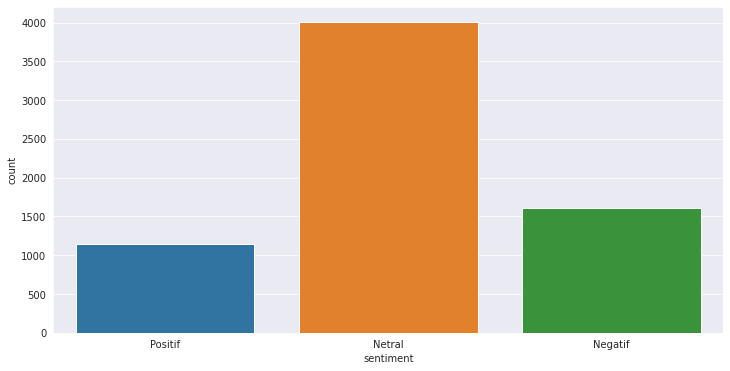

In [98]:
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')
sns.countplot(x='sentiment',data=df)

In [99]:
group_sent = df.groupby(['sentiment']).sum()
group_sent['sentiment'] = group_sent.index
group_sent

id  total_retweets  ...    month  sentiment
sentiment                                ...                    
Negatif    2.080787e+21          6127.0  ...  12492.0    Negatif
Netral     5.164606e+21         25666.0  ...  30804.0     Netral
Positif    1.477646e+21          2407.0  ...   8802.0    Positif

[3 rows x 8 columns]

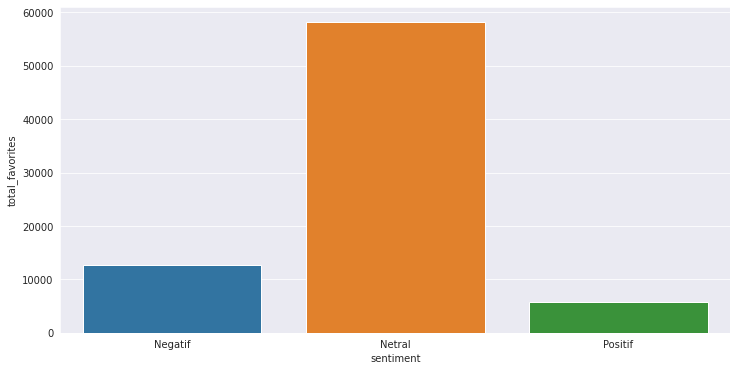

In [100]:
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')
sns.barplot(x='sentiment',y='total_favorites',data=group_sent)

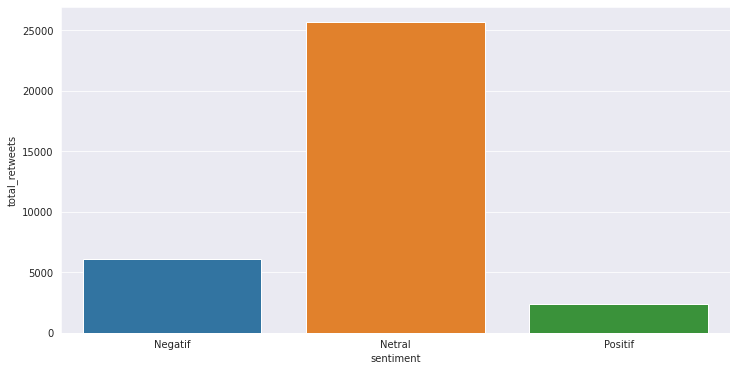

In [101]:
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')
sns.barplot(x='sentiment',y='total_retweets',data=group_sent)

In [102]:
df.head()

id  ... sentiment
0  1301815267954061312  ...   Positif
1  1301815086378491906  ...    Netral
2  1301814678675271681  ...    Netral
3  1301814467383050242  ...    Netral
4  1301814167431593984  ...   Negatif

[5 rows x 10 columns]

In [103]:
negatif = df[df['sentiment'] == 'Negatif']
negatif

id  ... sentiment
4     1301814167431593984  ...   Negatif
5     1301814038733623297  ...   Negatif
8     1301808956998733824  ...   Negatif
16    1301798625538908161  ...   Negatif
24    1301794483835555841  ...   Negatif
...                   ...  ...       ...
6754  1301351515089559552  ...   Negatif
6755  1301349365588529152  ...   Negatif
6756  1301337737065197568  ...   Negatif
6758  1301333883963625473  ...   Negatif
6760  1301329820802932736  ...   Negatif

[1613 rows x 10 columns]

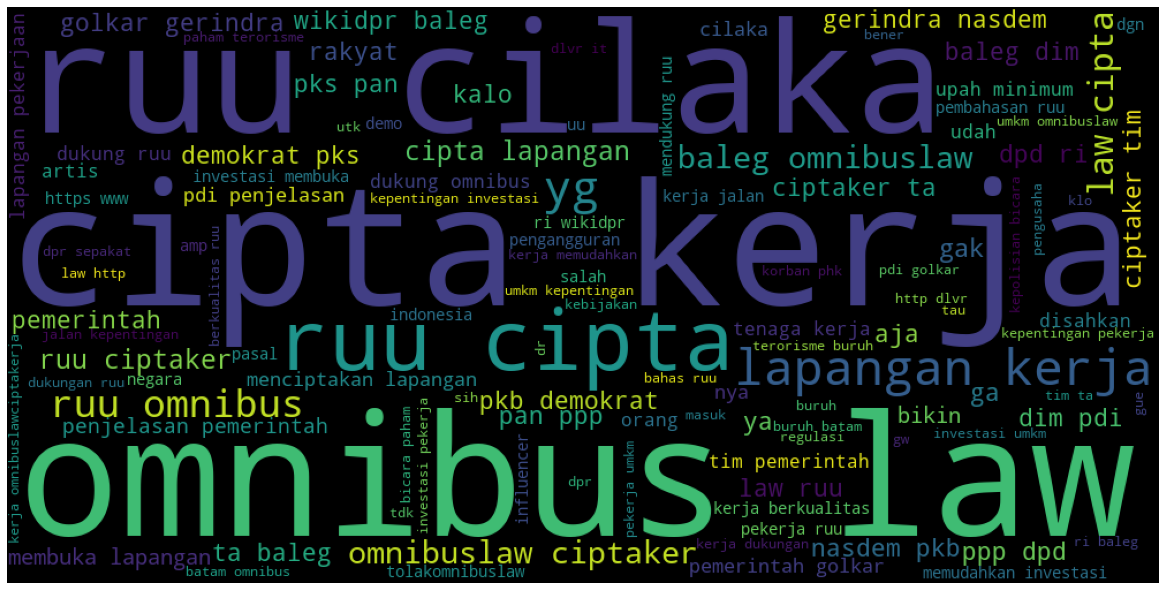

In [104]:
from wordcloud import WordCloud, STOPWORDS 
from nltk.corpus import stopwords

liststopwords =  set(stopwords.words('indonesian'))
tweets=''
for val in df['text'][df.sentiment == 'Negatif']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    tweets += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1000, height = 500, 
                background_color ='black', 
                stopwords = liststopwords, 
                min_font_size = 10).generate(tweets)
# plot the WordCloud image                        
plt.figure(figsize = (16, 9)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [105]:
tweets

'dengan omnibuslaw pengusaha wajib bayar lembur.. #dukungomnibuslaw serikat pekerja mendukung dan bekerjasama dalam membahas perjanjian kerja, upah, pesangon, phk, jaminan sosial dan kerja dalam omnibus law #dukungomnibuslaw omnibus law????? haaelaahhh sensi amad doi soal omnibus law, krpi minta prioritaskan kepentingan nasional bicara soal aturan dan kebijakan pemerintah juga #omnibuslaw kita \'kecolongan\', kata mba atiek dari api mengawali cerita pengalamannya di lapangan dg petani. pasal 46a ruu omnibus law cipta kerja perlindungan bagi korban phk #omnibuslaw dr. rina menambahkah terkait #reformaagraria yg merupakan jalan untuk menghilangkan ketimpangan struktur agraria. juga mengingatkan kita terkait bbrp pasal yg juga diperparah dg adanya #omnibuslaw padahal sebelumnya sudah baik. spt pasal2 yg dipaparkan bung gunawan. udah ada standart nya #omnibuslaw umkm maju bersama pemerintah #omnibuslaw ga boleh di bawah upah minimum #omnibuslaw menguntungkan buruh #omnibuslaw umkm maju #om

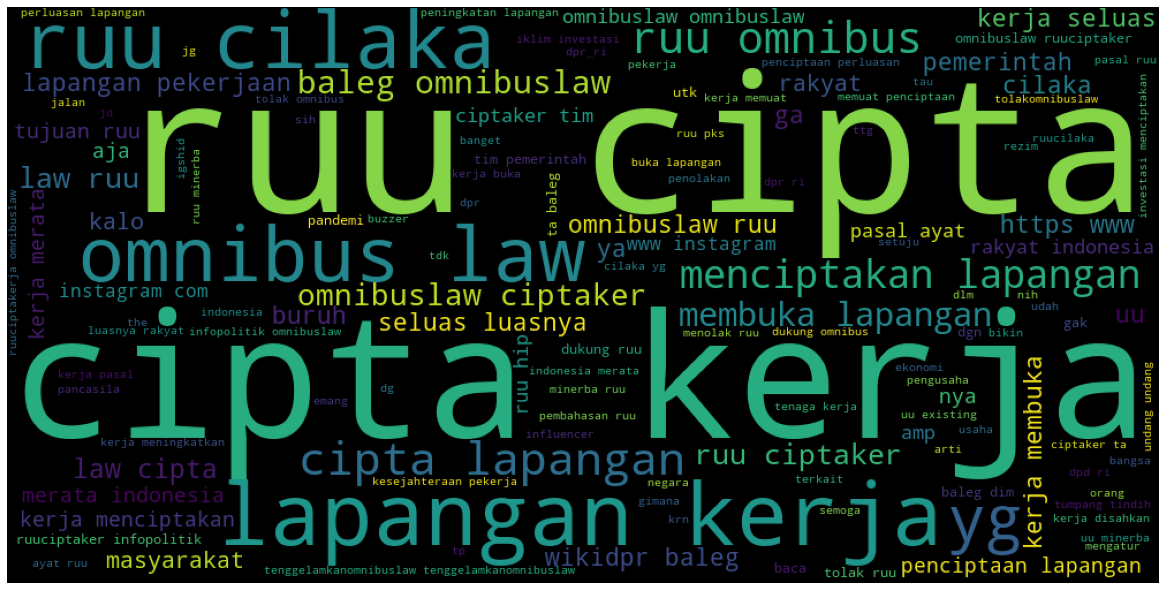

In [106]:
from wordcloud import WordCloud, STOPWORDS 
from nltk.corpus import stopwords

liststopwords =  set(stopwords.words('indonesian'))
tweets=''
for val in df['text'][df.sentiment == 'Netral']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    tweets += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1000, height = 500, 
                background_color ='black', 
                stopwords = liststopwords, 
                min_font_size = 10).generate(tweets)
# plot the WordCloud image                        
plt.figure(figsize = (16, 9)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

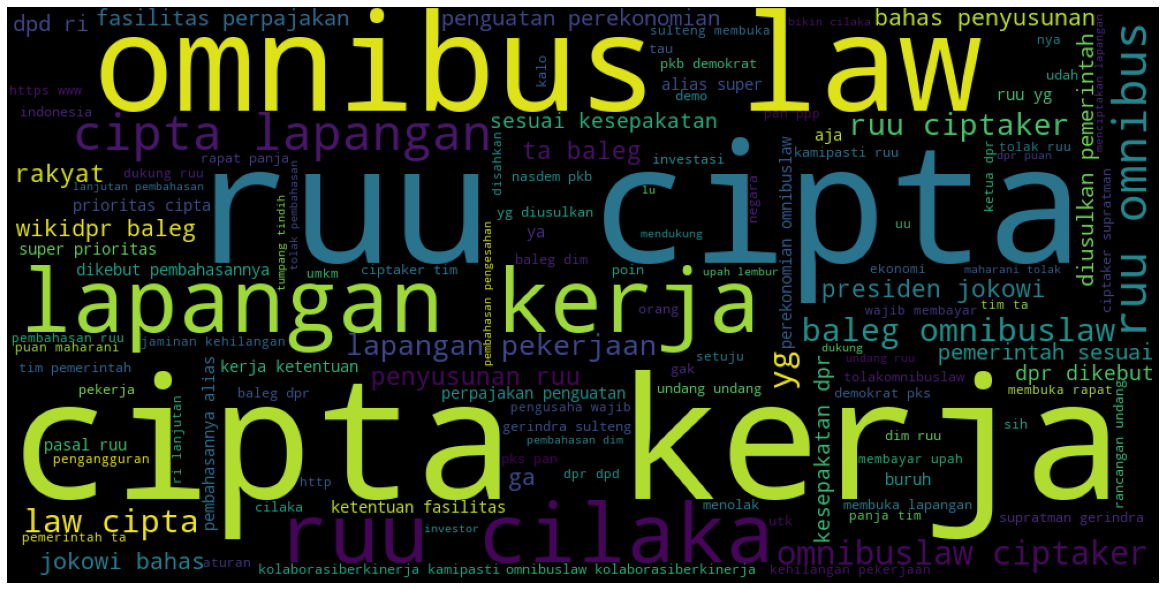

In [107]:
from wordcloud import WordCloud, STOPWORDS 
from nltk.corpus import stopwords

liststopwords =  set(stopwords.words('indonesian'))
tweets=''
for val in df['text'][df.sentiment == 'Positif']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    tweets += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1000, height = 500, 
                background_color ='black', 
                stopwords = liststopwords, 
                min_font_size = 10).generate(tweets)
# plot the WordCloud image                        
plt.figure(figsize = (16, 9)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

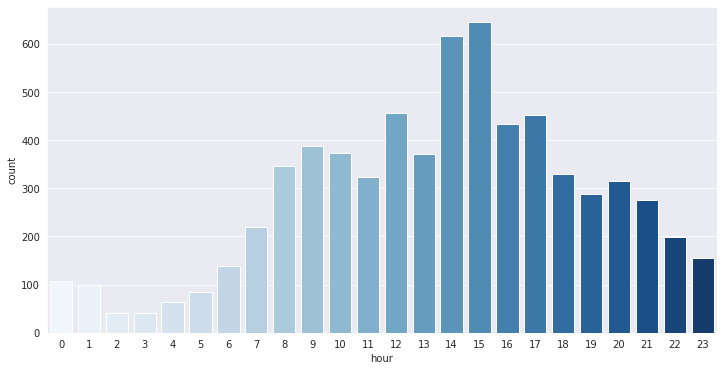

In [108]:
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')
sns.countplot(x='hour',data=df,palette='Blues')

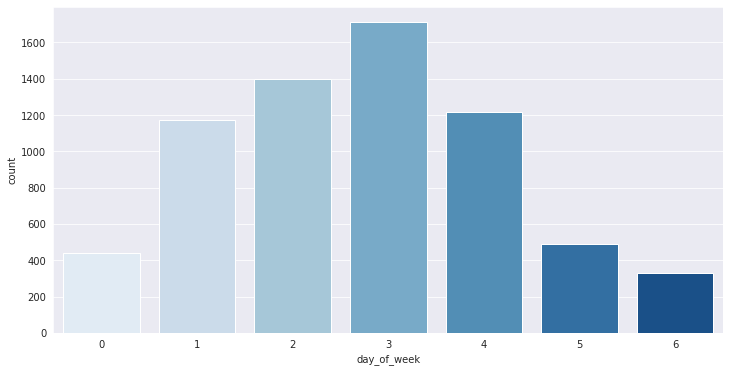

In [109]:
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')
sns.countplot(x='day_of_week',data=df,palette='Blues')

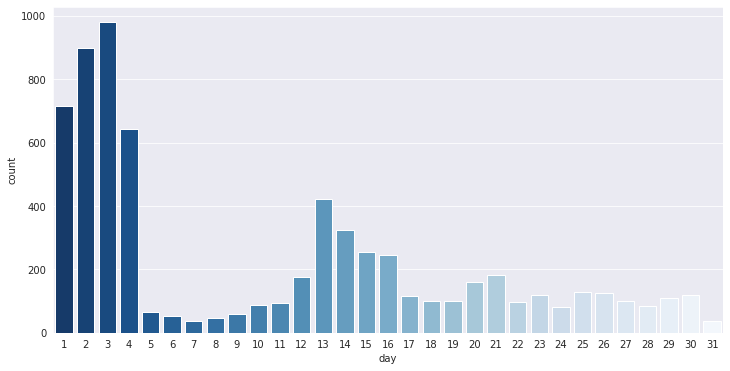

In [110]:
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')
sns.countplot(x='day',data=df,palette='Blues_r')

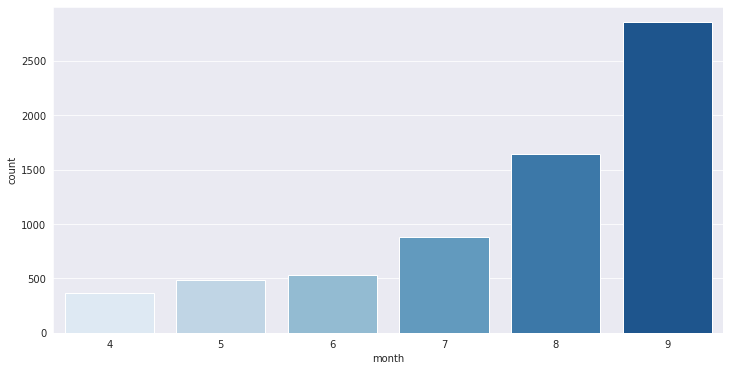

In [111]:
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')
sns.countplot(x='month',data=df,palette='Blues')

In [112]:
group_date = df.groupby('dates').agg('count')
group_date

id  text  total_retweets  ...  day  month  sentiment
dates                                                ...                       
2020-04-18 19:42:44+07:00   1     1               1  ...    1      1          1
2020-04-18 21:01:59+07:00   1     1               1  ...    1      1          1
2020-04-18 21:16:55+07:00   1     1               1  ...    1      1          1
2020-04-18 21:50:55+07:00   1     1               1  ...    1      1          1
2020-04-19 00:26:53+07:00   1     1               1  ...    1      1          1
...                        ..   ...             ...  ...  ...    ...        ...
2020-09-04 16:31:17+07:00   1     1               1  ...    1      1          1
2020-09-04 16:32:01+07:00   1     1               1  ...    1      1          1
2020-09-04 16:32:56+07:00   1     1               1  ...    1      1          1
2020-09-04 16:48:28+07:00   1     1               1  ...    1      1          1
2020-09-04 16:52:35+07:00   1     1               1  ...    1      1          1

[6262 rows x 9 columns]